# Tutorial on repertoire traditions discovery with PyCantus

In this tutorial we demonstrate one possible way how to research repertoire structure of Gregorian chant with [Pycantus library](https://github.com/dact-chant/PyCantus/tree/main) on [CantusCorpus v1.0](https://github.com/DvorakovaA/CantusCorpus/tree/main/cantuscorpus_1.0) dataset.

The approach of community detection in networks (graphs) with Louvain community detection ([Blondel et.al., 2008]( doi:10.1088/1742-5468/2008/10/P10008)) will be demonstrated . 
For that we are going to use Python `networkx` library.

In [1]:
import pycantus
from pycantus import data

import copy

## Load dataset
We are going to use [Cantus Corpus v1.0](https://github.com/DvorakovaA/CantusCorpus/tree/main/cantuscorpus_1.0) dataset, that can be loaded from available datasets of PyCantus.

In [2]:
cantuscorpus = data.load_dataset("cantuscorpus_v1.0", load_editable=True, 
                                  create_missing_sources=True)
print(f'Number of chants in corpus before any processing: {len(cantuscorpus.chants)}')
print(f'Number of sources in corpus before any processing: {len(cantuscorpus.sources)}')

Loading chants and sources...
Creating missing sources...
0 missing sources created!
Data loaded!
Number of chants in corpus before any processing: 888010
Number of sources in corpus before any processing: 2278


## Filter chants
1. We do not want to work with fragments of sources. 

2. We want to work with antiphons and responsories only.

3. We want to drop sources that remain empty after this filtration.

In [3]:
# 1. We do not want to work with fragments of sources.
# So we would try to get to that via dropping sources with less than 150 chants.
cantuscorpus.drop_small_sources_data(min_chants=150)
print(f'Number of chants after dropping sources with less than 150 chants: {len(cantuscorpus.chants)}')
print(f'Number of sources after dropping sources with less than 150 chants: {len(cantuscorpus.sources)}')

Number of chants after dropping sources with less than 150 chants: 860792
Number of sources after dropping sources with less than 150 chants: 473


In [4]:
# 2. We want to work with antiphons and responsories.
# So we would construct Filter wih such parameters.
from pycantus.filtration import Filter
a_r_filter = Filter('a_r_filter')
a_r_filter.add_value_include('genre', ['A', 'R']) # A = antiphon, R = responsory
a_r_cantuscorpus = copy.copy(cantuscorpus)
a_r_cantuscorpus.apply_filter(a_r_filter)
print(f'Number of chants after filtering only antiphons and responsories: {len(a_r_cantuscorpus.chants)}')

Number of chants after filtering only antiphons and responsories: 382578


In [5]:
# 3. Drop sources that are empty after this filtration.
a_r_cantuscorpus.drop_empty_sources()
print(f'Number of sources after dropping empty sources: {len(a_r_cantuscorpus.sources)}')

Number of sources after dropping empty sources: 427


## Feasts selection
For more meaningful search we want to look at only a subset of repertoire at each search. Good way to divide the mass of chants is based on feasts they are prescribed for.  
  
We would pick Purification of Mary feast day tradition for example.   

In [6]:
feast_filter = Filter('feast_filter')
feast_filter.add_value_include('feast', ['Purificatio Mariae'])

purification_cantuscorpus = copy.copy(a_r_cantuscorpus)
purification_cantuscorpus.apply_filter(feast_filter)
purification_cantuscorpus.drop_empty_sources() # Clean after filtering

print(f'Number of chants in Purification of Mary corpus: {len(purification_cantuscorpus.chants)}')
print(f'Number of sources in Purification of Mary corpus: {len(purification_cantuscorpus.sources)}')

Number of chants in Purification of Mary corpus: 4389
Number of sources in Purification of Mary corpus: 233


## Community detection
For demonstration of Gregorian chant repertoire research we would use Louvain community detection algorithm.
  
The Louvain algorithm detects communities in networks by maximising modularity (the ratio between within-community edge weights compared to links between different communities). 
It iterates community assignment and merging steps (as indicated in figure bellow).
Importantly, it does not require setting a target number of communities in advance. 
  
In our approach, each source is a vertex, each pair of sources is connected by an edge, and
edge weights are computed simply by the Jaccard index (intersection over union, see figure bellow)
between the sets of Cantus IDs (CID) present in the two sources after filter application (e.g.
feast selection).  
  
We use Louvain implementation from the [networx](https://networkx.org/) Python library. 
The resolution parameter is set to 1.0, which we found to be most robust to the randomness inherent in the Louvain algorithm. Also seed is set (to 42), because order of nodes at the first iteration effects the result and networx implementation shuffles the nodes before running the algorithm, seed affects this shuffle.

![Schema of Louvain algorithm and Jaccard distance.](img/louvain.png)

Here follows two functions that would help us construct graph (network):

In [7]:
def jaccard_distance(set1 : set, set2 : set) -> float:
    """
    Compute Jaccard distance between two sets. 
    Intersection over union.
    If both sets are empty, returns 0.0.
    """
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    if union_size == 0:
        return 0.0
    return intersection_size / union_size

In [8]:
def get_corpus_jaccard_distance(corpus : pycantus.models.Corpus) -> dict[tuple[str, str], float]:
    """
    Compute Jaccard distance between all pairs of sources in the given corpus.
    Returns a dictionary with keys as tuples of source sigla and values as Jaccard distances.
    """
    jaccard_distance_pairs = {}
    for i, source1 in enumerate(corpus.sources):
        chants1 = set(ch.cantus_id for ch in corpus.chants if ch.srclink == source1.srclink)
        for j, source2 in enumerate(corpus.sources):
            if i >= j:
                continue
            chants2 = set(ch.cantus_id for ch in corpus.chants if ch.srclink == source2.srclink)
            distance = jaccard_distance(chants1, chants2)
            jaccard_distance_pairs[(source1.siglum, source2.siglum)] = distance
    return jaccard_distance_pairs

In [9]:
# Libraries for community detection and visualization
import networkx as nx
import matplotlib.pyplot as plt

To be able to search for communities we need to construct the graph (network).  
For that we need:
- list of nodes (vertices): `purification_nodes_id`
- list of edges with weights (=Jaccard distances) computed: `purification_edges_id`

In [10]:
# Prepare edges and nodes for the graph
purification_nodes_id = [source.siglum for source in purification_cantuscorpus.sources]

purification_jaccard_distance_pairs = get_corpus_jaccard_distance(purification_cantuscorpus)
purification_edges_id = [(i, j, {'weight': weight}) for (i, j), weight in purification_jaccard_distance_pairs.items() if weight > 0.0 and i != j]

Number of nodes in the graph (=sources): 233
Number of communities found: 2


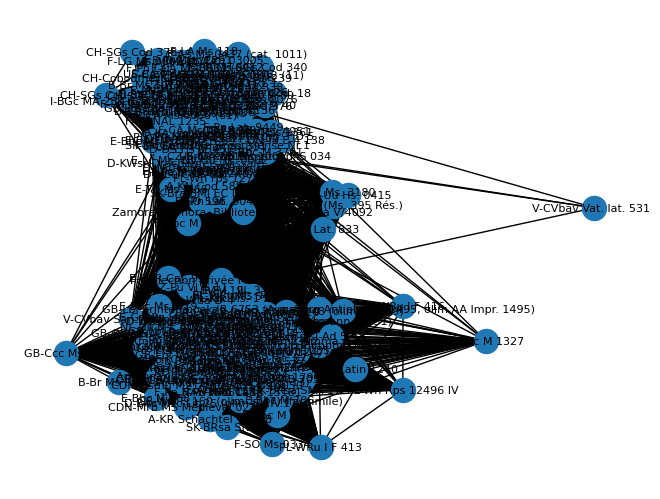

In [11]:
# Construct graph
graph_purification = nx.Graph()
graph_purification.add_nodes_from(purification_nodes_id)
graph_purification.add_edges_from(purification_edges_id)
# Search for communities
marian_comms = nx.community.louvain_communities(graph_purification, weight='weight', resolution=1.0, seed=42) # list of sets

print(f'Number of nodes in the graph (=sources): {len(graph_purification.nodes)}')
print(f'Number of communities found: {len(marian_comms)}')

pos = nx.spring_layout(graph_purification, k = 0.5, iterations=50, seed=42)
nx.draw(graph_purification, pos=pos, with_labels = True, font_size = 8)

Ugh... that is not very useful...  
We can kind of see the two communities but the result is of almost no use like this.  
  
Maybe we should try smaller unit, e.g. only some office.

In [12]:
lauds_filter = Filter('lauds_filter')
lauds_filter.add_value_include('office', ['L']) # L = Lauds
purification_lauds_cantuscorpus = copy.copy(purification_cantuscorpus)
purification_lauds_cantuscorpus.apply_filter(lauds_filter)
purification_lauds_cantuscorpus.drop_empty_sources()
print(f'Number of chants in Marian Lauds corpus: {len(purification_lauds_cantuscorpus.chants)}')
print(f'Number of sources in Marian Lauds corpus: {len(purification_lauds_cantuscorpus.sources)}')

Number of chants in Marian Lauds corpus: 624
Number of sources in Marian Lauds corpus: 106


In [13]:
# Prepare edges and nodes for the graph
purification_lauds_nodes_id = [source.siglum for source in purification_lauds_cantuscorpus.sources]

purification_lauds_jaccard_distance_pairs = get_corpus_jaccard_distance(purification_lauds_cantuscorpus)
purification_lauds_edges_id = [(i, j, {'weight': weight}) for (i, j), weight in purification_lauds_jaccard_distance_pairs.items() if weight > 0.0 and i != j]

Number of nodes in the graph (=sources): 106
Number of communities found: 4


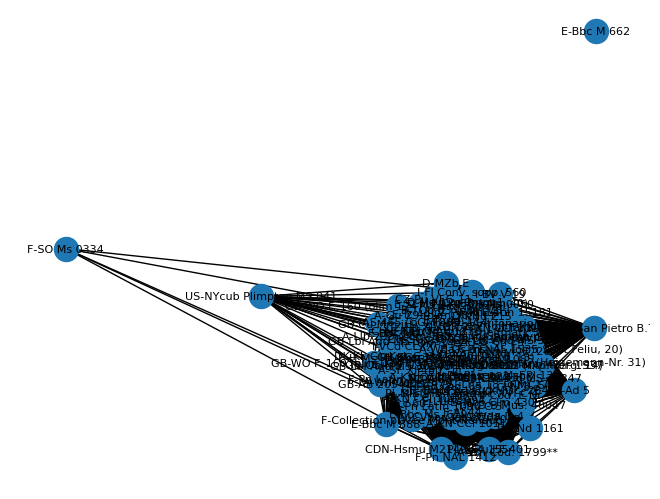

In [14]:
# Construct graph
graph_purification_lauds = nx.Graph()
graph_purification_lauds.add_nodes_from(purification_lauds_nodes_id)
graph_purification_lauds.add_edges_from(purification_lauds_edges_id)
# Search for communities
purification_lauds_comms = nx.community.louvain_communities(graph_purification_lauds, weight='weight', resolution=1.0, seed=42) # list of sets

print(f'Number of nodes in the graph (=sources): {len(graph_purification_lauds.nodes)}')
print(f'Number of communities found: {len(purification_lauds_comms)}')

pos = nx.spring_layout(graph_purification_lauds, k = 0.5, iterations=50, seed=42)
nx.draw(graph_purification_lauds, pos=pos, with_labels = True, font_size = 8)

Ok... we see a outlier but the rest is just mess.  
What we can try is to inspect the sizes of communities...

In [15]:
# Inspect communities sizes
for i, comm in enumerate(purification_lauds_comms):
    print('community', i+1, ':', len(comm))

community 1 : 29
community 2 : 35
community 3 : 41
community 4 : 1


...or make each community in a different color:

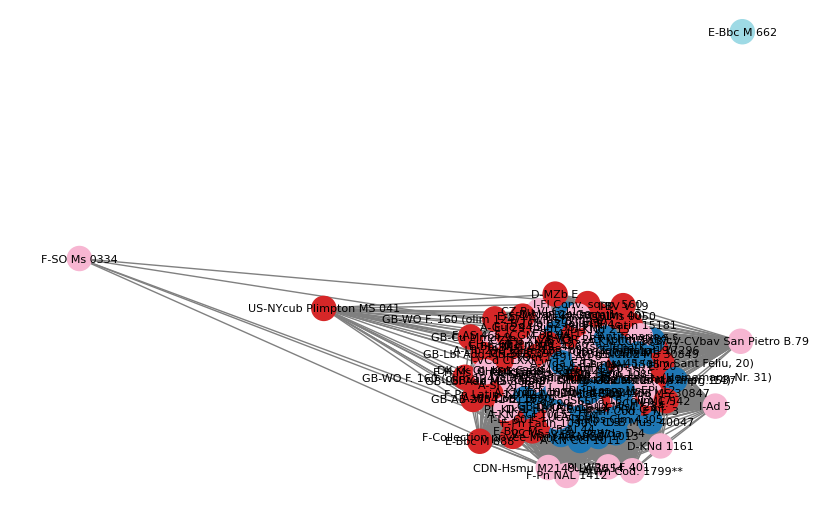

In [16]:
# Assign community index to each node
node2comm = {}
for comm_idx, comm_nodes in enumerate(purification_lauds_comms):
    for node in comm_nodes:
        node2comm[node] = comm_idx

# Get colors for each node based on community
node_colors = [node2comm[node] for node in graph_purification_lauds.nodes()]

# Draw graph
pos = nx.spring_layout(graph_purification_lauds, k=0.5, iterations=50, seed=42)
plt.figure(figsize=(8, 5))
nx.draw(
    graph_purification_lauds, pos,
    with_labels=True, font_size=8,
    node_color=node_colors, cmap=plt.cm.tab20,  # tab20 gives up to 20 distinct colors
    node_size=300, edge_color="gray"
)

plt.show()

So, maybe even smaller unit...?  
What about some more regional feast, e.g. Saint Adalbert.

In [17]:
# Filter the Cantus corpus bigger sources antiphons and responsories for chants of Saint Adalbert
adalbert_filter = Filter('adalbert_filter')
adalbert_filter.add_value_include('feast', ['Adalberti'])
adalbert_cantuscorpus = copy.copy(a_r_cantuscorpus)
adalbert_cantuscorpus.apply_filter(adalbert_filter)
adalbert_cantuscorpus.drop_empty_sources()
print(f'Number of chants in Adalbert corpus: {len(adalbert_cantuscorpus.chants)}')
print(f'Number of sources in Adalbert corpus: {len(adalbert_cantuscorpus.sources)}')

Number of chants in Adalbert corpus: 167
Number of sources in Adalbert corpus: 14


In [18]:
# Prepare edges and nodes for the graph
adalbert_nodes_id = [source.siglum for source in adalbert_cantuscorpus.sources]

adalbert_jaccard_distance_pairs = get_corpus_jaccard_distance(adalbert_cantuscorpus)
adalbert_edges_id = [(i, j, {'weight': weight}) for (i, j), weight in adalbert_jaccard_distance_pairs.items() if weight > 0.0 and i != j]

Number of nodes in the graph (=sources): 14
Number of communities found: 5


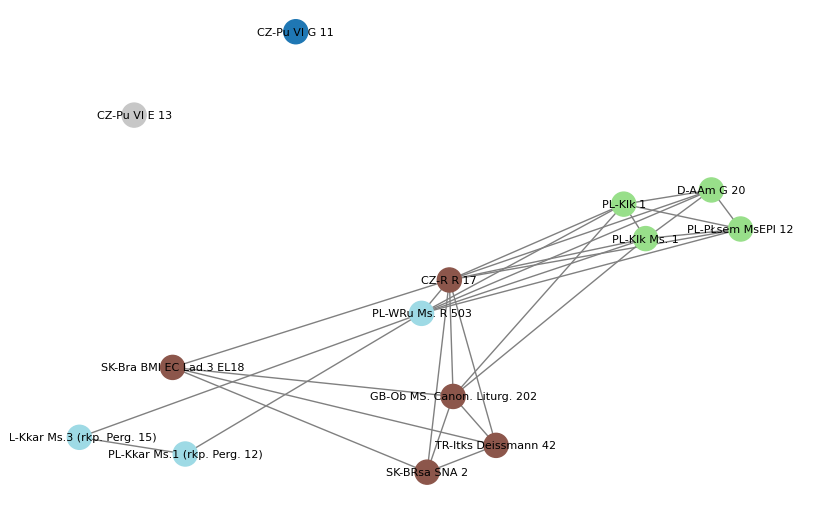

In [19]:
# Construct graph
graph_adalbert = nx.Graph()
graph_adalbert.add_nodes_from(adalbert_nodes_id)
graph_adalbert.add_edges_from(adalbert_edges_id)
# Search for communities
adalbert_comms = nx.community.louvain_communities(graph_adalbert, weight='weight', resolution=1.0, seed=42) # list of sets

print(f'Number of nodes in the graph (=sources): {len(graph_adalbert.nodes)}')
print(f'Number of communities found: {len(adalbert_comms)}')


# Assign community index to each node
node2comm = {}
for comm_idx, comm_nodes in enumerate(adalbert_comms):
    for node in comm_nodes:
        node2comm[node] = comm_idx

# Get colors for each node based on community
node_colors = [node2comm[node] for node in graph_adalbert.nodes()]

# Draw graph
pos = nx.spring_layout(graph_adalbert, k=0.5, iterations=50, seed=42)
plt.figure(figsize=(8, 5))
nx.draw(
    graph_adalbert, pos,
    with_labels=True, font_size=8,
    node_color=node_colors, cmap=plt.cm.tab20,  # tab20 gives up to 20 distinct colors
    node_size=300, edge_color="gray"
)

plt.show()

Well, that seems more clear and understandable.  
Also three and three sources from Poland coming together, two Czech outliers, Moravian (CZ-R) together with sources from Slovakia...  
  
To see how strong connections in the communities are, we can try to plot also edge weights:  
(no edges means edge of weight 0.0 = no shared cantus IDs between sources)

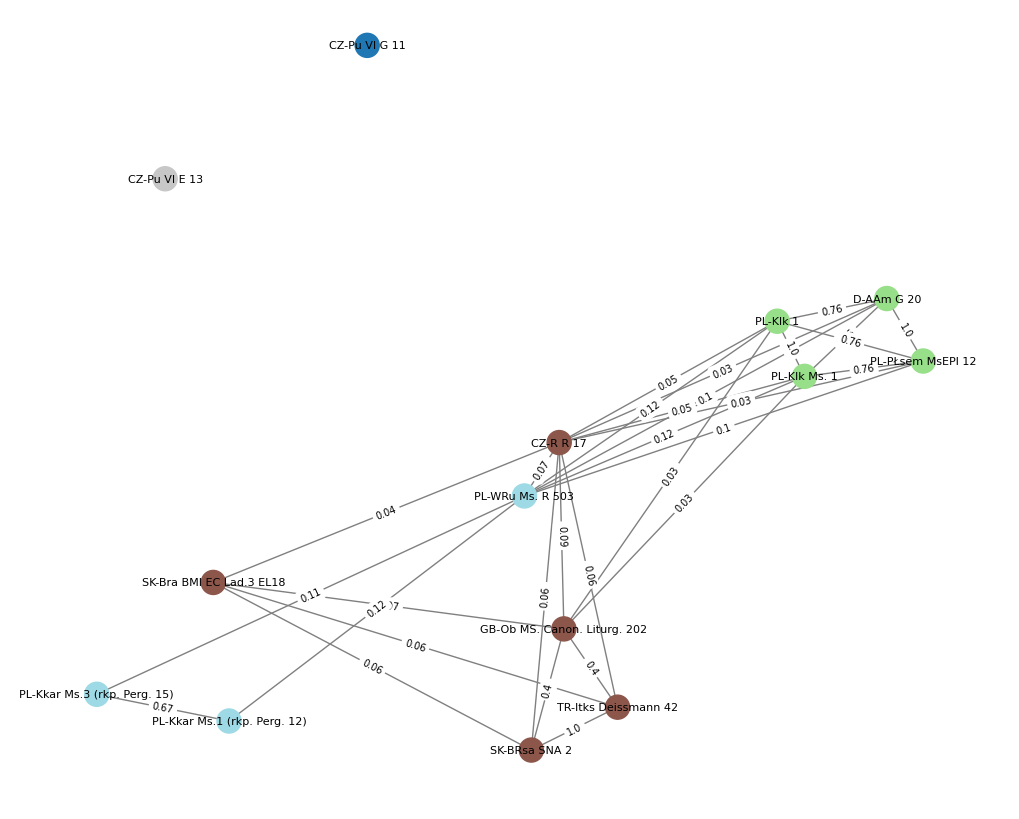

In [20]:
# Draw graph
pos = nx.spring_layout(graph_adalbert, k=0.5, iterations=50, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(
    graph_adalbert, pos,
    with_labels=True, font_size=8,
    node_color=node_colors, cmap=plt.cm.tab20,  # tab20 gives up to 20 distinct colors
    node_size=300, edge_color="gray"
)

# Extract edge weights
edge_labels = nx.get_edge_attributes(graph_adalbert, "weight")
for key, value in edge_labels.items():
    edge_labels[key] = f'{round(value,2)}'#f'{value:.2f}'  # Format to 2 decimal places
    
# Draw edge labels (weights)
nx.draw_networkx_edge_labels(
    graph_adalbert, pos,
    edge_labels=edge_labels,
    font_size=7, label_pos=0.5
)

plt.show()

That makes the layout a bit less nice but gives us some good insides.   
To be able to think about the result in a complex way, information about nodes sizes is also needed.  
Having connection of weight 1.0 (= completely same set of chants), has slightly different meaning when being between sources with 3 chants in consideration or sources with 20 such chants.

In [21]:
# How many chants have each source in Adalbert corpus?
sources_sizes_adalbert = {}
for source in adalbert_cantuscorpus.sources:
    chants_in_source = [ch for ch in adalbert_cantuscorpus.chants if ch.srclink == source.srclink]
    print(f'{source.siglum} : {len(chants_in_source)}')
    sources_sizes_adalbert[source.siglum] = len(chants_in_source)

CZ-Pu VI G 11 : 3
D-AAm G 20 : 16
GB-Ob MS. Canon. Liturg. 202 : 14
PL-KIk Ms. 1 : 22
PL-Klk 1 : 22
PL-WRu Ms. R 503 : 8
SK-BRsa SNA 2 : 16
TR-Itks Deissmann 42 : 16
CZ-Pu VI E 13 : 1
PL-PŁsem MsEPl 12 : 17
PL-Kkar Ms.1 (rkp. Perg. 12) : 2
PL-Kkar Ms.3 (rkp. Perg. 15) : 3
CZ-R R 17 : 25
SK-Bra BMI EC Lad.3 EL18 : 2


But probably in this case to plot the number of used chants in sources into the graph directly (here bold number following the siglum node label) is a cleaner way of inspecting this :

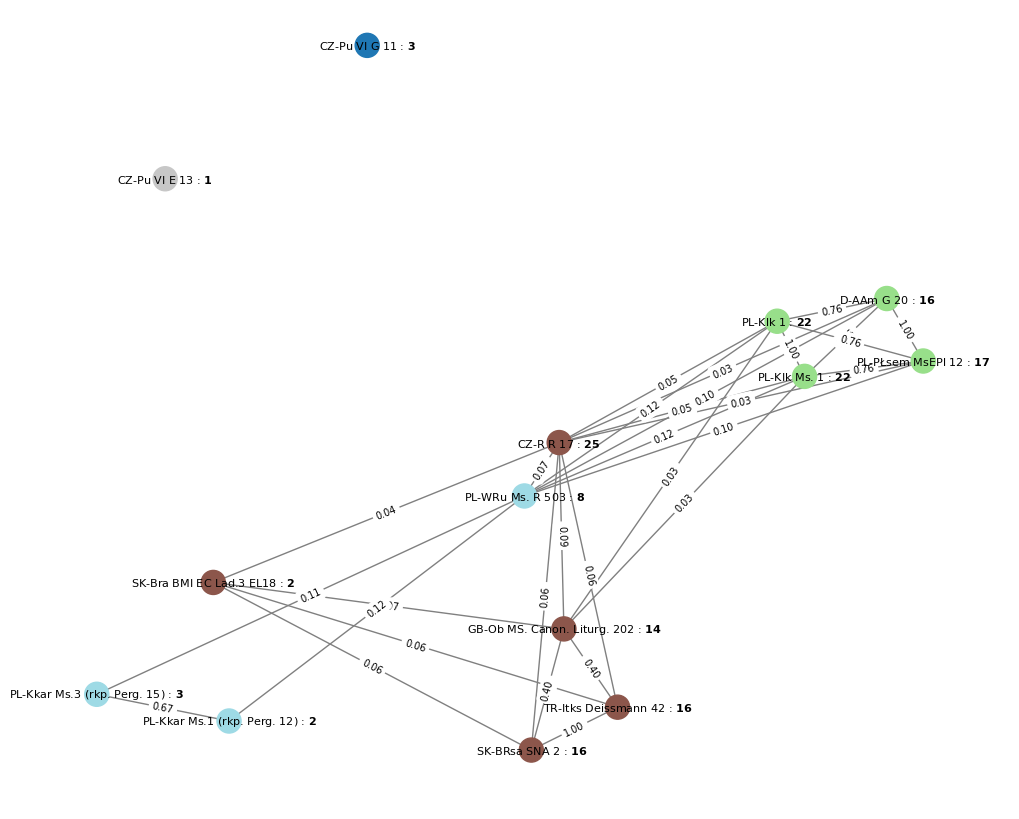

In [22]:
# Define custom labels: add a number of chants after each node label
labels = {node: fr"{node} : $\bf{{{i}}}$" for node, i in sources_sizes_adalbert.items()}

# Colors by community
node_colors = [node2comm[node] for node in graph_adalbert.nodes()]

# Layout
pos = nx.spring_layout(graph_adalbert, k=0.5, iterations=50, seed=42)

plt.figure(figsize=(10, 8))

# Draw nodes + edges
nx.draw(
    graph_adalbert, pos,
    with_labels=False,  # turn off auto labels
    node_color=node_colors, cmap=plt.cm.tab20,
    node_size=300, edge_color="gray"
)

# Draw custom labels
nx.draw_networkx_labels(graph_adalbert, pos, labels=labels, font_size=8)

# Edge labels (weights)
edge_labels = {e: f"{w:.2f}" for e, w in nx.get_edge_attributes(graph_adalbert, "weight").items()}
nx.draw_networkx_edge_labels(graph_adalbert, pos, edge_labels=edge_labels, font_size=7)

plt.show()


Having all this information in the graph visualization shows that what the community detection algorithm returns can sometimes be "blurry".  
For example the light blue community:
- PL-Kkar Ms.1 (rkp. Perg. 12) : 2
- PL-Kkar Ms.3 (rkp. Perg. 15) : 3
- PL-WRu Ms. R 503 : 8

First two are only stored in the same institution but also shares 2 out of 2 or 3 chants making it 2/3 edge.  
The third source is further as being tight also to other sources by non-zero edges.
It even has an edge out of the community with same weight as to source "inside", which can be confusing, but is something that can happened due to the functioning of the algorithm (edges inside the green community are much "stronger").

#### ChantMapper
This approach is implemented in the [ChantMapper](https://chantmapper.owx.cz/map_repertoire/) web application where, among other things, map interface is available.  
*Purificatio Mariae* plotted on map of Europe would look approximately like this when looking at antiphons and responsories of Lauds.  
  
Maps A-D show individual traditions computed via
Louvain community detection, E shows them all. Map F shows results constructed at the granularity of [Cantus Analysis Tool](https://cantusindex.org/analyse) provided by [Cantus Index](https://cantusindex.org/),
which results in 35 small communities, obscuring rather than exposing broader trends.

![Mapping the Lauds from Purificatio Mariae. ](img/purif.png)

What we saw on the Saint Adalbert example is that we might want to look into when the subset is this small. That is something ChantMapper also offers as a synoptic table:  

![Synoptic table from ChantMapper.](img/table.png)


(This is a not related example just to show the option.)

## Other genre
Compare to what [ChantMapper](https://chantmapper.owx.cz/map_repertoire/) currently offers we could look at other genre, e.g. kind of specific Tropes (as [Eipert and Moss, 2023](https://dlfm.web.ox.ac.uk/sites/default/files/dlfm/documents/media/poster2023_eipert_communities.pdf) did).

In [23]:
# First prepare corpus of tropes in a similar way as above.
cantuscorpus = data.load_dataset("cantuscorpus_v1.0", load_editable=True, 
                                  create_missing_sources=True)
cantuscorpus.drop_small_sources_data(min_chants=150)
tropes_filter = Filter('tropes_filter')
tropes_filter.add_value_include('genre', ['Tp']) # Tp = trope
tropes_cantuscorpus = copy.copy(cantuscorpus)
tropes_cantuscorpus.apply_filter(tropes_filter)

Loading chants and sources...
Creating missing sources...
0 missing sources created!
Data loaded!


In [24]:
print(f'Number of chants in tropes corpus: {len(tropes_cantuscorpus.chants)}')


Number of chants in tropes corpus: 10294


That is a lot, let's break it into smaller units based on feasts.

In [25]:
john_evangelist_filter = Filter('john_evangelist_filter')
john_evangelist_filter.add_value_include('feast', ['Joannis Evang.'])
john_evangelist_cantuscorpus = copy.copy(tropes_cantuscorpus)
john_evangelist_cantuscorpus.apply_filter(john_evangelist_filter)
print(f'Number of chants for John the Evangelist in tropes corpus after filtering: {len(john_evangelist_cantuscorpus.chants)}')
john_evangelist_cantuscorpus.drop_empty_sources()
print(f'Number of sources for John the Evangelist in tropes corpus after filtering: {len(john_evangelist_cantuscorpus.sources)}')

Number of chants for John the Evangelist in tropes corpus after filtering: 474
Number of sources for John the Evangelist in tropes corpus after filtering: 29


In [26]:
# Prepare edges and nodes for the graph
john_nodes_id = [source.siglum for source in john_evangelist_cantuscorpus.sources]
john_jaccard_distance_pairs = get_corpus_jaccard_distance(john_evangelist_cantuscorpus)
john_edges_id = [(i, j, {'weight': weight}) for (i, j), weight in john_jaccard_distance_pairs.items() if weight > 0.0 and i != j]

Number of nodes in the graph (=sources): 29
Number of communities found: 4


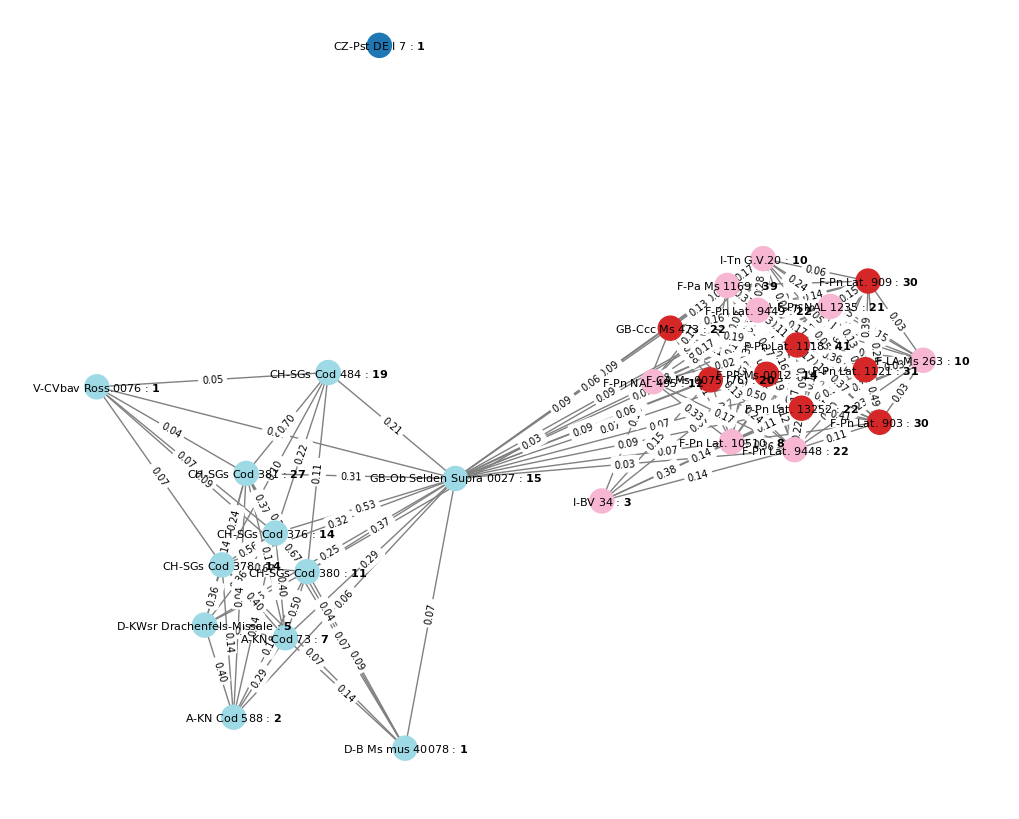

In [27]:
# Construct graph
graph_john = nx.Graph()
graph_john.add_nodes_from(john_nodes_id)
graph_john.add_edges_from(john_edges_id)
# Search for communities
john_comms = nx.community.louvain_communities(graph_john, weight='weight', resolution=1.0, seed=42) # list of sets
print(f'Number of nodes in the graph (=sources): {len(graph_john.nodes)}')
print(f'Number of communities found: {len(john_comms)}')

# Assign community index to each node
node2comm = {}
for comm_idx, comm_nodes in enumerate(john_comms):
    for node in comm_nodes:
        node2comm[node] = comm_idx

# Define custom labels: add a number of chants after each node label
sources_sizes_john = {}
for source in john_evangelist_cantuscorpus.sources:
    chants_in_source = [ch for ch in john_evangelist_cantuscorpus.chants if ch.srclink == source.srclink]
    sources_sizes_john[source.siglum] = len(chants_in_source)

labels = {node: fr"{node} : $\bf{{{i}}}$" for node, i in sources_sizes_john.items()}

# Colors by community
node_colors = [node2comm[node] for node in graph_john.nodes()]

# Layout
pos = nx.spring_layout(graph_john, k=0.5, iterations=50, seed=42)

plt.figure(figsize=(10, 8))

# Draw nodes + edges
nx.draw(
    graph_john, pos,
    with_labels=False,  # turn off auto labels
    node_color=node_colors, cmap=plt.cm.tab20,
    node_size=300, edge_color="gray"
)

# Draw custom labels
nx.draw_networkx_labels(graph_john, pos, labels=labels, font_size=8)

# Edge labels (weights)
edge_labels = {e: f"{w:.2f}" for e, w in nx.get_edge_attributes(graph_john, "weight").items()}
nx.draw_networkx_edge_labels(graph_john, pos, edge_labels=edge_labels, font_size=7)

plt.show()

Here we again experience not very clear situation, in this case edge labels are kind of too much for the visualization, but!
    
If we see an edge of a low weight such as the 0.05 between **V-CVbav Ross 0076** and **CH-SGs Cod 484** in left top part of the plotted graph it does not necessarily mean the sources are different in terms of chant pieces; here we see 1/19 = 0.05, so the only Trope for John the Evangelist in the source from CH-SGs... is also present in V-CVbav... just the ratio of sizes is very different, which also can indicate something about traditions of course. Without the "size of the source considered subset" info we might for example assume these sources are very different of similar size. 

If you would like to see Tropes or any other genre in ChantMapper you can export such subset of CantusCorpus v1.0 with PyCantus (see `01_intro_to_pycantus.ipynb` tutorial) and then upload it to ChantMapper as custom dataset.

## Replicability remark - How to do this again later in a same way?
1. Try to use well documented datasets (so you know to what does the filepath leads)
2. Do not rewrite values or take good notes when you do so.
3. Save operations history before you finish your work.

In [28]:
# Print operations history
print(john_evangelist_cantuscorpus.get_operations_history_string())

chants file: cantuscorpus_v1.0/chants.csv
sources file: cantuscorpus_v1.0/sources.csv

drop_small_sources_data
min_chants: 150

apply_filter
name: tropes_filter
include_values:
  genre:
  - Tp
exclude_values: {}

apply_filter
name: john_evangelist_filter
include_values:
  feast:
  - Joannis Evang.
exclude_values: {}

drop_empty_sources
{}



In [29]:
# Save operations history to a file to be able to replicate the same steps later
with open('john_evangelist_tropes_history.txt', 'w', encoding='utf-8') as f:
    f.write(john_evangelist_cantuscorpus.get_operations_history_string())